In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import datetime
import sys
sys.path.append('..')
import src.tools as tools

#RFM Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

In [2]:
a = pd.read_csv('../data/Year 2009-2010.csv', encoding='unicode_escape')
b = pd.read_csv('../data/Year 2010-2011.csv', encoding='unicode_escape')
retail = pd.concat([a,b], ignore_index=True)

Prepare dataframe

In [3]:
retail.columns= retail.columns.str.lower()
retail.drop_duplicates(inplace=True)
retail = retail.query("country=='United Kingdom'").reset_index(drop=True)
retail.invoicedate = pd.to_datetime(retail.invoicedate)
retail['year'] = retail.invoicedate.dt.year
retail['month'] = retail.invoicedate.dt.month
retail['week'] = retail.invoicedate.dt.isocalendar().week
retail['day'] = retail.invoicedate.dt.day
retail['hour'] = retail.invoicedate.dt.hour
retail['revenue'] = retail.price * retail.quantity
retail = retail.query("year>2009").reset_index(drop=True)
retail = retail.query("quantity>0").reset_index(drop=True)
retail = retail.query("price>0").reset_index(drop=True)
retail = retail.dropna()

Define customers

In [4]:
min_date = retail.groupby(['customer id'])['invoicedate'].min().reset_index()
max_date = retail.groupby(['customer id'])['invoicedate'].max().reset_index()
min_date.columns = ['customer id', 'min_date']
max_date.columns = ['customer id', 'max_date']
min_date = pd.merge(min_date, max_date, on='customer id')
min_date['customer_months'] = min_date['max_date'] - min_date['min_date']
min_date['customer_months'] = min_date['customer_months'] / np.timedelta64(1,'M')
min_date['customer_months'] = min_date['customer_months'].astype(int)
min_date.drop(columns=['min_date','max_date'], inplace=True)
retail = pd.merge(retail, min_date, on='customer id')
retail.sample()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
525100,553149,23174,REGENCY SUGAR BOWL GREEN,24,2011-05-13 14:16:00,3.75,14226.0,United Kingdom,2011,5,19,13,14,90.0,13


### OVERVIEW

In [5]:
total = retail.groupby('year')['quantity','revenue'].sum().transpose()
total['%Δ'] = (total[2011] / total[2010] -1)*100
total

/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2810/429543714.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total = retail.groupby('year')['quantity','revenue'].sum().transpose()


year,2010,2011,%Δ
quantity,4197329.000,3974732.000,-5.303301
revenue,6990340.983,6788547.304,-2.886750


### TRENDS

In [6]:
retail_lines = retail[['invoicedate','quantity','revenue']]
retail_lines.sample()

,invoicedate,quantity,revenue
339917,2010-08-20 12:28:00,200,290.0


In [7]:
retail_lines.invoicedate = pd.to_datetime(retail_lines.invoicedate).dt.strftime('%Y-%m')
retail_lines = retail_lines.groupby('invoicedate')['quantity','revenue'].sum().reset_index()
retail_lines['item_price'] = retail_lines.revenue / retail_lines.quantity

/opt/homebrew/Caskroom/miniconda/base/envs/ironhack/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2810/148635078.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  retail_lines = retail_lines.groupby('invoicedate')['quantity','revenue'].sum().reset_index()


In [8]:
retail_lines['qty_indx'] = retail_lines.quantity / retail_lines.quantity[0]
retail_lines['rev_indx'] = retail_lines.revenue / retail_lines.revenue[0]
retail_lines['itemprice_indx'] = retail_lines.item_price / retail_lines.item_price[0]

In [9]:
retail_lines.head()

,invoicedate,quantity,revenue,item_price,qty_indx,rev_indx,itemprice_indx
0,2010-01,236118,415120.502,1.758106,1.000000,1.000000,1.000000
1,2010-02,234173,409265.826,1.747707,0.991763,0.985896,0.994085
2,2010-03,384039,587165.941,1.528923,1.626471,1.414447,0.869642
3,2010-04,290254,500798.551,1.725380,1.229275,1.206393,0.981386
4,2010-05,326996,501394.560,1.533335,1.384884,1.207829,0.872152


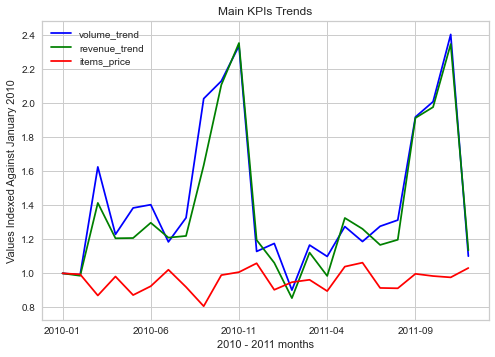

In [10]:
retail_lines.groupby('invoicedate')['qty_indx'].sum().plot(label='volume_trend', color='Blue')
retail_lines.groupby('invoicedate')['rev_indx'].sum().plot(label='revenue_trend', color='Green')
retail_lines.groupby('invoicedate')['itemprice_indx'].sum().plot(label='items_price', color='Red')

plt.title('Main KPIs Trends')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against January 2010')

plt.legend()
plt.show()

### SEGMENTATION

In [11]:
(retail.customer_months.value_counts(normalize=True)*100).sort_index()

0      6.206527
1      1.781305
2      1.834558
3      1.976467
4      1.812394
5      1.328058
6      1.395442
7      1.681790
8      2.266534
9      1.790081
10     1.641329
11     2.260435
12     4.396960
13     3.819802
14     3.010442
15     2.308779
16     3.381876
17     4.147205
18     4.388183
19     6.871300
20     9.954482
21    12.264898
22    14.529498
23     4.951656
Name: customer_months, dtype: float64

#### RFM

Customers for RFM

In [12]:
retail_23 = retail.query('customer_months>=12').reset_index(drop=True)
df_2y = tools.rfm(retail_23)
df_2y.head()

,customer id,recency,frequency,monetary
0,12346.0,325,29,77442.96
1,16550.0,108,686,7743.51
2,14680.0,24,1146,54369.76
3,14709.0,14,349,8630.13
4,13798.0,0,699,74143.71


Drop outliers

In [13]:
df_2y['z_recency'] = stats.zscore(df_2y.recency)
df_2y['z_frequency'] = stats.zscore(df_2y.frequency)
df_2y['z_monetary'] = stats.zscore(df_2y.monetary)

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,2000.00000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03
mean,57.95050,248.820500,5381.116346,2.131628e-17,-2.842171e-17,2.842171e-17
std,65.43603,441.098933,17105.376929,1.000250e+00,1.000250e+00,1.000250e+00
min,0.00000,2.000000,30.950000,-8.858269e-01,-5.596981e-01,-3.128551e-01
25%,11.00000,67.750000,1179.985000,-7.176817e-01,-4.106013e-01,-2.456644e-01
50%,31.00000,146.000000,2416.900000,-4.119633e-01,-2.331591e-01,-1.733348e-01
75%,77.00000,292.000000,4869.597500,2.911892e-01,9.791522e-02,-2.991146e-02
max,333.00000,11921.000000,539981.300000,4.204385e+00,2.646821e+01,3.126116e+01


In [14]:
df_2y = df_2y[(df_2y.z_recency >= -2) & (df_2y.z_recency <= 2) &
         (df_2y.z_frequency >= -2) & (df_2y.z_frequency <= 2) &
         (df_2y.z_monetary >= -2) & (df_2y.z_monetary <= 2)]

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000
mean,46.300885,213.419248,3917.169640,-0.178075,-0.080277,-0.085605
std,45.691480,206.191832,4567.645962,0.698436,0.467567,0.267097
min,0.000000,2.000000,30.950000,-0.885827,-0.559698,-0.312855
25%,11.000000,69.000000,1227.015000,-0.717682,-0.407767,-0.242914
50%,30.000000,146.000000,2424.330000,-0.427249,-0.233159,-0.172900
75%,66.000000,283.000000,4650.717500,0.123044,0.077507,-0.042711
max,188.000000,1125.000000,36528.560000,1.987927,1.986853,1.821371


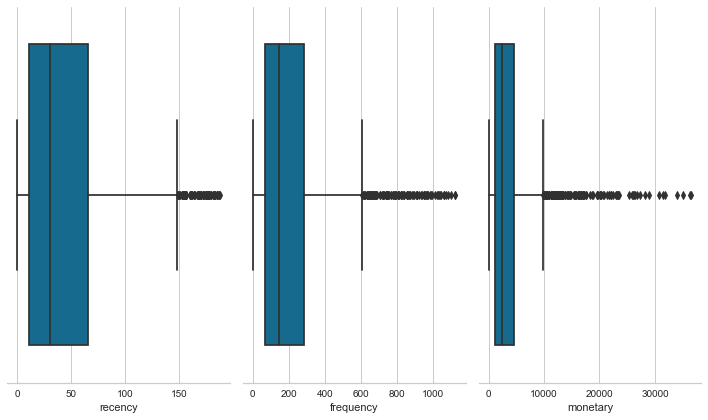

In [15]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.boxplot(x=df_2y.recency, color="b", ax=axes[0])
sns.boxplot(x=df_2y.frequency, color="b", ax=axes[1])
sns.boxplot(x=df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

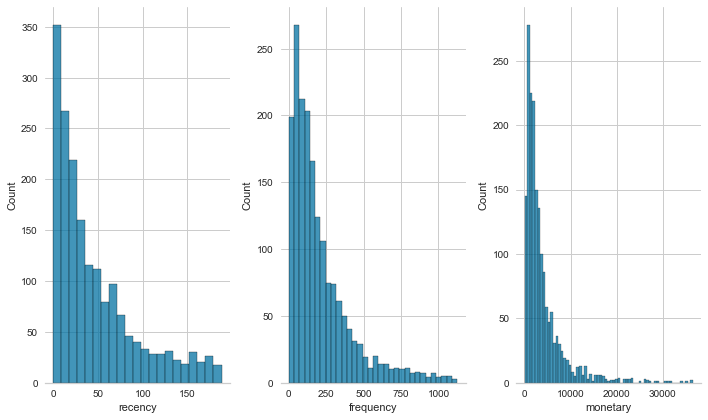

In [16]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.histplot(df_2y.recency, color="b", ax=axes[0])
sns.histplot(df_2y.frequency, color="b", ax=axes[1])
sns.histplot(df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [17]:
print(stats.jarque_bera(df_2y.recency)[1] < 0.05)
print(stats.jarque_bera(df_2y.frequency)[1] < 0.05)
print(stats.jarque_bera(df_2y.monetary)[1] < 0.05)

True
True
True


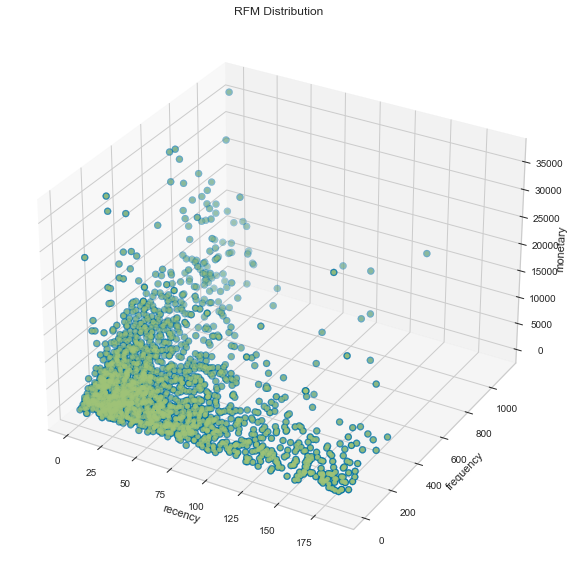

In [18]:
fig = plt.figure()

fig.set_size_inches(10, 10)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary)

colormap='Blues'

#ax.grid(False)


plt.show()

Elbow method to define K means

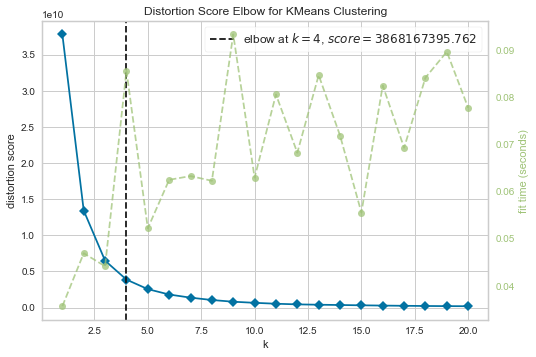

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))

visualizer.fit(df_2y[['recency', 'frequency', 'monetary']])
visualizer.show();

Kmeans analysis

In [20]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2y[['recency', 'frequency', 'monetary']])
df_2y['clusters'] = kmeans.predict(df_2y[['recency', 'frequency', 'monetary']])
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters
1606,15969.0,2,35,1127.05,-0.855255,-0.484866,-0.248760,0
528,15023.0,2,958,11578.65,-0.855255,1.608158,0.362406,1
1801,14480.0,10,48,995.67,-0.732968,-0.455387,-0.256442,0


In [21]:
(df_2y.clusters.value_counts(normalize=True)*100).sort_index()

0    66.703540
1     7.024336
2    24.115044
3     2.157080
Name: clusters, dtype: float64

In [22]:
df_2y.drop(columns='customer id').groupby(['clusters']).median()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
clusters,,,,,,
0,39.0,102.0,1591.8450,-0.289676,-0.332935,-0.221581
1,13.0,453.0,11959.2700,-0.687110,0.463004,0.384663
2,22.0,286.0,5378.4105,-0.549537,0.084309,-0.000158
3,7.0,586.0,23172.7200,-0.778825,0.764599,1.040378


In [23]:
weighted = df_2y.drop(columns='customer id').groupby(['clusters']).median()
weighted['recency'] = weighted['recency']/weighted['recency'].min()
weighted['frequency'] = weighted['frequency']/weighted['frequency'].max()
weighted['monetary'] = weighted['monetary']/weighted['monetary'].max()
weighted['segment'] = (weighted.frequency * weighted.monetary) / weighted.recency
weighted['segment'] = weighted.segment.rank(ascending=False)
weighted.sort_values(by='segment')

,recency,frequency,monetary,z_recency,z_frequency,z_monetary,segment
clusters,,,,,,,
3,1.000000,1.000000,1.000000,-0.778825,0.764599,1.040378,1.0
1,1.857143,0.773038,0.516093,-0.687110,0.463004,0.384663,2.0
2,3.142857,0.488055,0.232101,-0.549537,0.084309,-0.000158,3.0
0,5.571429,0.174061,0.068695,-0.289676,-0.332935,-0.221581,4.0


In [24]:
df_2y = pd.merge(df_2y, weighted['segment'], on='clusters')
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters,segment
795,18151.0,134,106,1879.44,1.162487,-0.323864,-0.204763,0,4.0
272,17238.0,2,1060,6771.77,-0.855255,1.839457,0.081320,2,3.0
1306,13302.0,154,3,159.20,1.468205,-0.557430,-0.305356,0,4.0


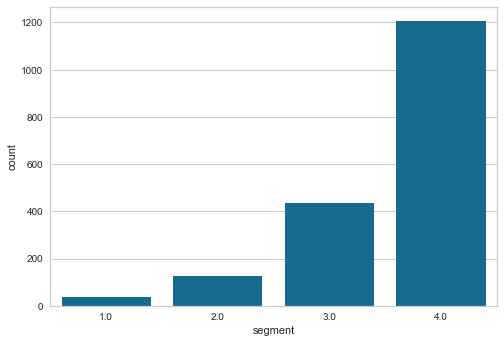

In [25]:
sns.countplot(x=df_2y.segment, color="b");

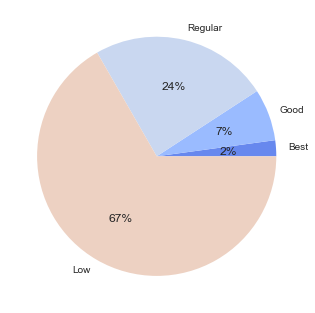

In [26]:
colors = sns.color_palette('coolwarm')[0:5]

plt.pie((df_2y.segment.value_counts(normalize=True)*100).sort_index(ascending=True), autopct='%.0f%%', 
        labels=['Best','Good','Regular','Low'],
       colors=colors)

plt.show();

In [27]:
y = pd.DataFrame(df_2y.groupby('segment')['customer id'].count()).reset_index()
y

,segment,customer id
0,1.0,39
1,2.0,127
2,3.0,436
3,4.0,1206


In [28]:
x = pd.DataFrame(df_2y.groupby('segment')['recency','frequency','monetary'].median().astype(int)).reset_index()
x.segment.replace({1:'Best',2:'Good',3:'Regular',4:'Low'},inplace=True)

/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2810/722221762.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = pd.DataFrame(df_2y.groupby('segment')['recency','frequency','monetary'].median().astype(int)).reset_index()


In [29]:
x.set_index('segment')

,recency,frequency,monetary
segment,,,
Best,7,586,23172
Good,13,453,11959
Regular,22,286,5378
Low,39,102,1591


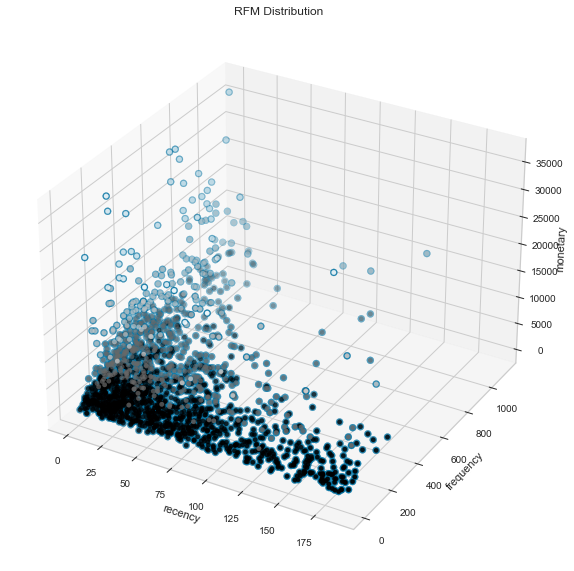

In [30]:
fig = plt.figure()

fig.set_size_inches(10, 10)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary, c=df_2y.segment, )

colormap='Blues'

#ax.grid(False)


plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


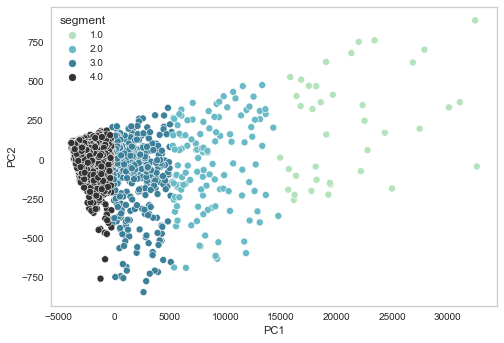

In [31]:
pca = PCA(2)
data_t = pd.DataFrame(pca.fit_transform(df_2y.drop(columns='customer id')), columns=["PC1", "PC2"])

sns.set_style("whitegrid", {'axes.grid' : False})

sns.scatterplot(data_t["PC1"],data_t["PC2"], hue=df_2y['segment'], palette='GnBu_d');

In [32]:
retail2y = pd.merge(retail_23, df_2y[['customer id', 'segment']], on='customer id')
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months,segment
267783,561071,22629,SPACEBOY LUNCH BOX,24,2011-07-24 15:39:00,1.95,14057.0,United Kingdom,2011,7,29,24,15,46.8,19,3.0
277326,559297,22553,PLASTERS IN TIN SKULLS,4,2011-07-07 12:36:00,1.65,16743.0,United Kingdom,2011,7,27,7,12,6.6,18,3.0
129816,526757,21326,AGED GLASS SILVER T-LIGHT HOLDER,48,2010-10-13 10:31:00,0.65,16843.0,United Kingdom,2010,10,41,13,10,31.2,20,1.0


Forecast customers behavior

In [33]:
#retail2y.groupby(['year','month','segment'])['revenue'].sum().unstack().fillna(0)

In [34]:
# COUNT
dfx1 = retail2y[retail2y.segment == 1]

dfx = pd.DataFrame(dfx1.groupby('invoicedate')['revenue'].count()).reset_index()
dfx.invoicedate = pd.to_datetime(dfx.invoicedate).dt.strftime('%Y-%m')

dfx = pd.DataFrame(dfx.groupby('invoicedate')['revenue'].sum())
dfx['index_'] = dfx.revenue / dfx.revenue[0]

#CLUSTER 2

dfx2 = retail2y[retail2y.segment == 2]

dfy = pd.DataFrame(dfx2.groupby('invoicedate')['revenue'].count()).reset_index()
dfy.invoicedate = pd.to_datetime(dfy.invoicedate).dt.strftime('%Y-%m')

dfy = pd.DataFrame(dfy.groupby('invoicedate')['revenue'].sum())
dfy['index_'] = dfy.revenue / dfy.revenue[0]


#CLUSTER 3

dfx3 = retail2y[retail2y.segment == 3]

dfz = pd.DataFrame(dfx3.groupby('invoicedate')['revenue'].count()).reset_index()
dfz.invoicedate = pd.to_datetime(dfz.invoicedate).dt.strftime('%Y-%m')

dfz = pd.DataFrame(dfz.groupby('invoicedate')['revenue'].sum())
dfz['index_'] = dfz.revenue / dfz.revenue[0]


#CLUSTER 4

dfx4 = retail2y[retail2y.segment == 4]

dfw = pd.DataFrame(dfx4.groupby('invoicedate')['revenue'].count()).reset_index()
dfw.invoicedate = pd.to_datetime(dfw.invoicedate).dt.strftime('%Y-%m')

dfw = pd.DataFrame(dfw.groupby('invoicedate')['revenue'].sum())
dfw['index_'] = dfw.revenue / dfw.revenue[0]


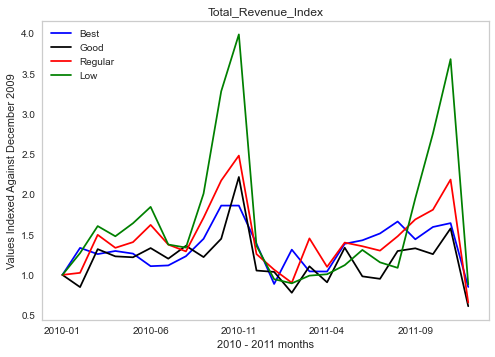

In [35]:
dfx.groupby('invoicedate')['index_'].sum().plot(label='Best', color='Blue')
dfy.groupby('invoicedate')['index_'].sum().plot(label='Good', color='Black')
dfz.groupby('invoicedate')['index_'].sum().plot(label='Regular', color='Red')
dfw.groupby('invoicedate')['index_'].sum().plot(label='Low', color='Green')

plt.title('Total_Revenue_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against December 2009')

plt.legend()
plt.show();

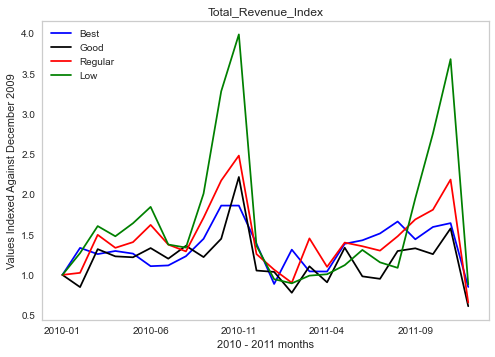

In [36]:
dfx.groupby('invoicedate')['index_'].mean().plot(label='Best', color='Blue')
dfy.groupby('invoicedate')['index_'].mean().plot(label='Good', color='Black')
dfz.groupby('invoicedate')['index_'].mean().plot(label='Regular', color='Red')
dfw.groupby('invoicedate')['index_'].mean().plot(label='Low', color='Green')

plt.title('Total_Revenue_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against December 2009')

plt.legend()
plt.show();

Time series

In [37]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster1 = retail2y[retail2y.segment == 1]
cluster1 = cluster1[['invoicedate', 'revenue']]

cluster2 = retail2y[retail2y.segment == 2]
cluster2 = cluster2[['invoicedate', 'revenue']]

cluster3 = retail2y[retail2y.segment == 3]
cluster3 = cluster3[['invoicedate', 'revenue']]

cluster4 = retail2y[retail2y.segment == 4]
cluster4 = cluster4[['invoicedate', 'revenue']]

In [38]:
cluster1.invoicedate = pd.to_datetime(cluster1.invoicedate).dt.strftime('%Y-%m')
cluster1 = pd.DataFrame(cluster1.groupby('invoicedate')['revenue'].sum())
cluster1['index_'] = cluster1.revenue / cluster1.revenue[0]

cluster2.invoicedate = pd.to_datetime(cluster2.invoicedate).dt.strftime('%Y-%m')
cluster2 = pd.DataFrame(cluster2.groupby('invoicedate')['revenue'].sum())
cluster2['index_'] = cluster2.revenue / cluster2.revenue[0]

cluster3.invoicedate = pd.to_datetime(cluster3.invoicedate).dt.strftime('%Y-%m')
cluster3 = pd.DataFrame(cluster3.groupby('invoicedate')['revenue'].sum())
cluster3['index_'] = cluster3.revenue / cluster3.revenue[0]

cluster4.invoicedate = pd.to_datetime(cluster4.invoicedate).dt.strftime('%Y-%m')
cluster4 = pd.DataFrame(cluster4.groupby('invoicedate')['revenue'].sum())
cluster4['index_'] = cluster4.revenue / cluster4.revenue[0]

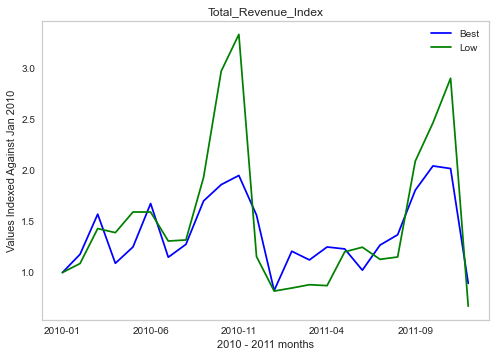

In [48]:
cluster1.groupby('invoicedate')['index_'].sum().plot(label='Best', color='Blue')
#cluster2.groupby('invoicedate')['index_'].sum().plot(label='Good', color='Black')
#cluster3.groupby('invoicedate')['index_'].sum().plot(label='Regular', color='Red')
cluster4.groupby('invoicedate')['index_'].sum().plot(label='Low', color='Green')

plt.title('Total_Revenue_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against Jan 2010')

plt.legend()
plt.show();

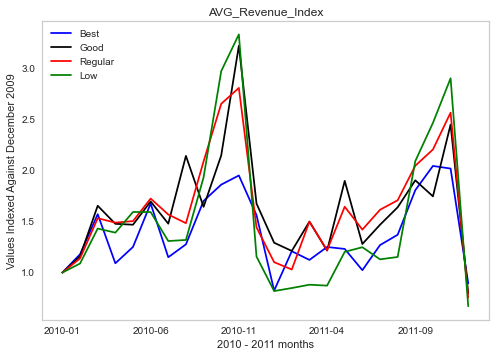

In [40]:
cluster1.groupby('invoicedate')['index_'].median().plot(label='Best', color='Blue')
cluster2.groupby('invoicedate')['index_'].median().plot(label='Good', color='Black')
cluster3.groupby('invoicedate')['index_'].median().plot(label='Regular', color='Red')
cluster4.groupby('invoicedate')['index_'].median().plot(label='Low', color='Green')

plt.title('AVG_Revenue_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against December 2009')

plt.legend()
plt.show();

In [41]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster11 = retail2y[retail2y.segment == 1]
cluster11 = cluster11[['invoicedate', 'quantity']]

cluster22 = retail2y[retail2y.segment == 2]
cluster22 = cluster22[['invoicedate', 'quantity']]

cluster33 = retail2y[retail2y.segment == 3]
cluster33 = cluster33[['invoicedate', 'quantity']]

cluster44 = retail2y[retail2y.segment == 4]
cluster44 = cluster44[['invoicedate', 'quantity']]

In [42]:
cluster11.invoicedate = pd.to_datetime(cluster11.invoicedate).dt.strftime('%Y-%m')
cluster11 = pd.DataFrame(cluster11.groupby('invoicedate')['quantity'].sum())
cluster11['index_'] = cluster11.quantity / cluster11.quantity[0]

cluster22.invoicedate = pd.to_datetime(cluster22.invoicedate).dt.strftime('%Y-%m')
cluster22 = pd.DataFrame(cluster22.groupby('invoicedate')['quantity'].sum())
cluster22['index_'] = cluster22.quantity / cluster22.quantity[0]

cluster33.invoicedate = pd.to_datetime(cluster33.invoicedate).dt.strftime('%Y-%m')
cluster33 = pd.DataFrame(cluster33.groupby('invoicedate')['quantity'].sum())
cluster33['index_'] = cluster33.quantity / cluster33.quantity[0]

cluster44.invoicedate = pd.to_datetime(cluster44.invoicedate).dt.strftime('%Y-%m')
cluster44 = pd.DataFrame(cluster44.groupby('invoicedate')['quantity'].sum())
cluster44['index_'] = cluster44.quantity / cluster44.quantity[0]

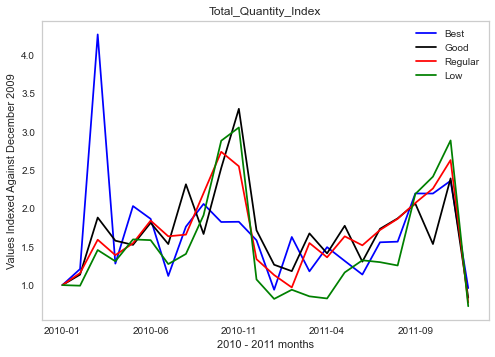

In [43]:
cluster11.groupby('invoicedate')['index_'].sum().plot(label='Best', color='Blue')
cluster22.groupby('invoicedate')['index_'].sum().plot(label='Good', color='Black')
cluster33.groupby('invoicedate')['index_'].sum().plot(label='Regular', color='Red')
cluster44.groupby('invoicedate')['index_'].sum().plot(label='Low', color='Green')

plt.title('Total_Quantity_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against December 2009')

plt.legend()
plt.show();

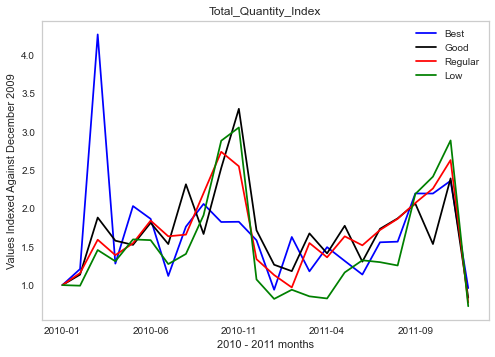

In [44]:
cluster11.groupby('invoicedate')['index_'].median().plot(label='Best', color='Blue')
cluster22.groupby('invoicedate')['index_'].median().plot(label='Good', color='Black')
cluster33.groupby('invoicedate')['index_'].median().plot(label='Regular', color='Red')
cluster44.groupby('invoicedate')['index_'].median().plot(label='Low', color='Green')

plt.title('Total_Quantity_Index')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against December 2009')

plt.legend()
plt.show();

def clean_ts (df):
    df.columns = ['ds','y']
    df.ds = pd.to_datetime(df.ds).dt.strftime('%Y-%m')
    #df['z_score'] = stats.zscore(df.y)
    #df = df[(df.z_score >= -3) & (df.z_score <= 3)]
    #df = df.drop(columns='z_score')"""
    df.set_index('ds', inplace=True)
    return df

Export

In [45]:
"""cluster1.to_csv('../data/ts_segment1.csv',index=False)
cluster2.to_csv('../data/ts_segment2.csv',index=False)
cluster3.to_csv('../data/ts_segment3.csv',index=False)
cluster4.to_csv('../data/ts_segment4.csv',index=False)""";

In [46]:
"""cluster11.to_csv('../data/ts_segment11.csv',index=False)
cluster22.to_csv('../data/ts_segment22.csv',index=False)
cluster33.to_csv('../data/ts_segment33.csv',index=False)
cluster44.to_csv('../data/ts_segment44.csv',index=False)""";